# setup

install packages required for TimesFormer

In [1]:
# install packages needed for TimeSformer
! pip install torchvision
! pip install 'git+https://github.com/facebookresearch/fvcore'
! pip install simplejson
! pip install einops
! pip install timm
! pip install psutil
! pip install scikit-learn
! pip install opencv-python
! pip install tensorboard
! pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

install TimeSformer

* we are using a version I forked - where I added some example data and fixed a few import issue so we can use with colab

In [2]:
! git clone https://github.com/yiyixuxu/TimeSformer.git

Cloning into 'TimeSformer'...
remote: Enumerating objects: 503, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 503 (delta 117), reused 90 (delta 90), pack-reused 338 (from 1)
Receiving objects: 100% (503/503), 2.89 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (200/200), done.


In [3]:
%cd TimeSformer

/content/TimeSformer


In [33]:
# export
from pathlib import Path
from timesformer.models.vit import *
from timesformer.datasets import utils as utils
from timesformer.config.defaults import get_cfg
from einops import rearrange, repeat, reduce
import cv2
from google.colab.patches import cv2_imshow
import torch
import torchvision.transforms as transforms
from PIL import Image
import json
import matplotlib.pyplot as plt
import av

# Utilities

In [30]:
# export
DEFAULT_MEAN = [0.45, 0.45, 0.45]
DEFAULT_STD = [0.225, 0.225, 0.225]
# convert video path to input tensor for model
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DEFAULT_MEAN,DEFAULT_STD),
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

# convert the video path to input for cv2_imshow()
transform_plot = transforms.Compose([
    lambda p: cv2.imread(str(p),cv2.IMREAD_COLOR),
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    lambda x: rearrange(x*255, 'c h w -> h w c').numpy()
])


def get_frames(path_to_video, num_frames=8):
  "return a list of paths to the frames of sampled from the video"

  # Check if the input is a video file
  if path_to_video.is_file() and path_to_video.suffix in ['.mp4', '.avi', '.mov']:  # Add other supported formats if needed

    # Create a directory to store extracted frames
    frames_dir = path_to_video.parent / (path_to_video.stem + '_frames')
    frames_dir.mkdir(exist_ok=True)

    # Extract frames using PyAV
    with av.open(str(path_to_video)) as container:
      stream = container.streams.video[0]
      for i, frame in enumerate(container.decode(stream)):
        frame_path = frames_dir / f'{i:06d}.jpg'  # Save frames as JPG
        frame.to_image().save(frame_path)

    # Get list of extracted frames
    path_to_frames = list(frames_dir.iterdir())
    path_to_frames.sort(key=lambda f: int(f.with_suffix('').name[-6:]))

  else:
    # If not a video file, assume it's a directory of frames
    path_to_frames = list(path_to_video.iterdir())
    path_to_frames.sort(key=lambda f: int(f.with_suffix('').name[-6:]))

  assert num_frames <= len(path_to_frames), "num_frames can't exceed the number of frames extracted from videos"

  # Sample frames
  if len(path_to_frames) == num_frames:
    return path_to_frames
  else:
    video_length = len(path_to_frames)
    seg_size = float(video_length - 1) / num_frames
    seq = []
    for i in range(num_frames):
      start = int(np.round(seg_size * i))
      end = int(np.round(seg_size * (i + 1)))
      seq.append((start + end) // 2)
    path_to_frames_new = [path_to_frames[p] for p in seq]
    return path_to_frames_new

def create_video_input(path_to_video):
  "create the input tensor for TimeSformer model"
  path_to_frames = get_frames(path_to_video)
  frames = [transform(cv2.imread(str(p), cv2.IMREAD_COLOR)) for p in path_to_frames]
  frames = torch.stack(frames, dim=0)
  frames = rearrange(frames, 't c h w -> c t h w')
  frames = frames.unsqueeze(dim=0)
  return(frames)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def create_masks(masks_in, np_imgs):
  masks = []
  for mask, img in zip(masks_in, np_imgs):
    mask= cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask = show_mask_on_image(img, mask)
    masks.append(mask)
  return(masks)

In [6]:
# export
def combine_divided_attention(attn_t, attn_s):
  ## time attention
    # average time attention weights across heads
  attn_t = attn_t.mean(dim = 1)
    # add cls_token to attn_t as an identity matrix since it only attends to itself
  I = torch.eye(attn_t.size(-1)).unsqueeze(0)
  attn_t = torch.cat([I,attn_t], 0)
    # adding identity matrix to account for skipped connection
  attn_t = attn_t +  torch.eye(attn_t.size(-1))[None,...]
    # renormalize
  attn_t = attn_t / attn_t.sum(-1)[...,None]

  ## space attention
   # average across heads
  attn_s = attn_s.mean(dim = 1)
   # adding residual and renormalize
  attn_s = attn_s +  torch.eye(attn_s.size(-1))[None,...]
  attn_s = attn_s / attn_s.sum(-1)[...,None]

  ## combine the space and time attention
  attn_ts = einsum('tpk, ktq -> ptkq', attn_s, attn_t)

  ## average the cls_token attention across the frames
   # splice out the attention for cls_token
  attn_cls = attn_ts[0,:,:,:]
   # average the cls_token attention and repeat across the frames
  attn_cls_a = attn_cls.mean(dim=0)
  attn_cls_a = repeat(attn_cls_a, 'p t -> j p t', j = 8)
   # add it back
  attn_ts = torch.cat([attn_cls_a.unsqueeze(0),attn_ts[1:,:,:,:]],0)
  return(attn_ts)

class DividedAttentionRollout():
  def __init__(self, model, **kwargs):
    self.model = model
    self.hooks = []

  def get_attn_t(self, module, input, output):
    self.time_attentions.append(output.detach().cpu())
  def get_attn_s(self, module, input, output):
    self.space_attentions.append(output.detach().cpu())

  def remove_hooks(self):
    for h in self.hooks: h.remove()

  def __call__(self, path_to_video):
    input_tensor = create_video_input(path_to_video)
    self.model.zero_grad()
    self.time_attentions = []
    self.space_attentions = []
    self.attentions = []
    for name, m in model.named_modules():
      if 'temporal_attn.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_t))
      elif 'attn.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_s))
    preds = self.model(input_tensor)
    for h in self.hooks: h.remove()
    for attn_t,attn_s in zip(self.time_attentions, self.space_attentions):
      self.attentions.append(combine_divided_attention(attn_t,attn_s))
    p,t = self.attentions[0].shape[0], self.attentions[0].shape[1]
    result = torch.eye(p*t)
    for attention in self.attentions:
      attention = rearrange(attention, 'p1 t1 p2 t2 -> (p1 t1) (p2 t2)')
      result = torch.matmul(attention, result)
    mask = rearrange(result, '(p1 t1) (p2 t2) -> p1 t1 p2 t2', p1 = p, p2=p)
    mask = mask.mean(dim=1)
    mask = mask[0,1:,:]
    width = int(mask.size(0)**0.5)
    mask = rearrange(mask, '(h w) t -> h w t', w = width).numpy()
    mask = mask / np.max(mask)
    return(mask)



# load the pretrained model

download the pre-trainde model

In [7]:
! wget https://dl.dropboxusercontent.com/s/tybhuml57y24wpm/TimeSformer_divST_8_224_SSv2.pyth

--2025-02-09 07:25:54--  https://dl.dropboxusercontent.com/s/tybhuml57y24wpm/TimeSformer_divST_8_224_SSv2.pyth
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 971325489 (926M) [application/octet-stream]
Saving to: ‘TimeSformer_divST_8_224_SSv2.pyth’

TimeSformer_divST_8 100%[===================>] 926.33M  22.7MB/s    in 31s     

2025-02-09 07:26:26 (29.9 MB/s) - ‘TimeSformer_divST_8_224_SSv2.pyth’ saved [971325489/971325489]



load the model

In [8]:
model_file = '/content/TimeSformer/TimeSformer_divST_8_224_SSv2.pyth'
Path(model_file).exists()

True

In [9]:
cfg = get_cfg()
cfg.merge_from_file('configs/SSv2/TimeSformer_divST_8_224.yaml')
cfg.TRAIN.ENABLE = False
cfg.TIMESFORMER.PRETRAINED_MODEL = model_file
model = MODEL_REGISTRY.get('vit_base_patch16_224')(cfg)

/content/TimeSformer/timesformer/models/helpers.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


read the labels

In [10]:
with open('example_data/labels.json') as f:
  ssv2_labels = json.load(f)
ssv2_labels = list(ssv2_labels.keys())

inference

In [28]:
path_to_video = Path('/content/video.mp4')
path_to_video.exists()

True

In [34]:
with torch.set_grad_enabled(False):
  np.random.seed(cfg.RNG_SEED)
  torch.manual_seed(cfg.RNG_SEED)
  model.eval();
  pred = model(create_video_input(path_to_video)).cpu().detach()

In [35]:
topk_scores, topk_label = torch.topk(pred, k=5, dim=-1)
for i in range(5):
  pred_name = ssv2_labels[topk_label.squeeze()[i].item()]
  print(f"Prediction index {i}: {pred_name:<25}, score: {topk_scores.squeeze()[i].item():.3f}")

Prediction index 0: Throwing something in the air and letting it fall, score: 8.048
Prediction index 1: Throwing something against something, score: 7.117
Prediction index 2: Throwing something in the air and catching it, score: 6.805
Prediction index 3: Bending something until it breaks, score: 6.662
Prediction index 4: Throwing something       , score: 6.133


# visualizing the learned space-time attention

Create a `DividedAttentionRollout` object (`att_roll`) and call it to get a mask for a given video

In [36]:
att_roll = DividedAttentionRollout(model)
masks = att_roll(path_to_video)

plot

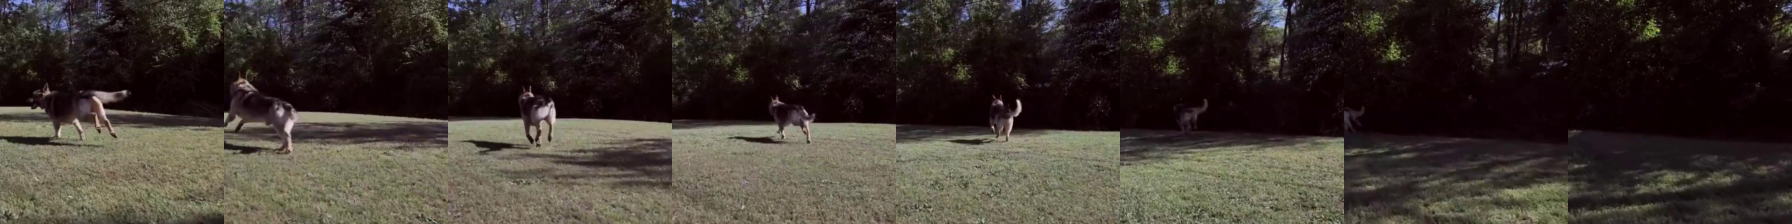

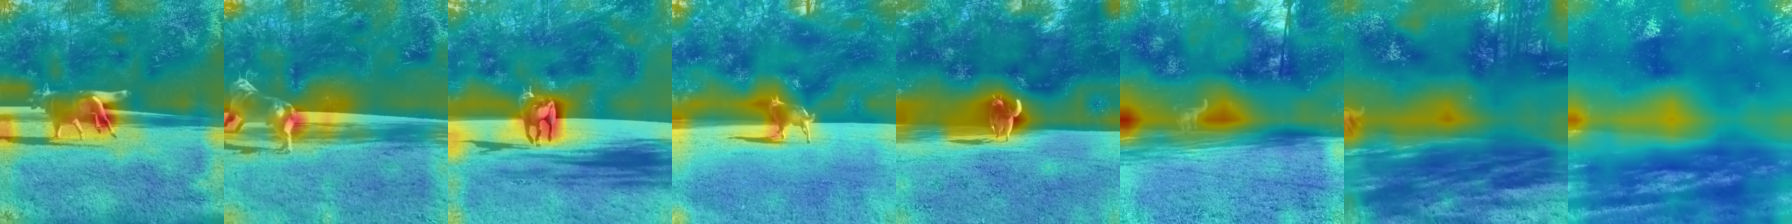

In [37]:
np_imgs = [transform_plot(p) for p in get_frames(path_to_video)]
masks = create_masks(list(rearrange(masks, 'h w t -> t h w')),np_imgs)
cv2_imshow(np.hstack(np_imgs))
cv2_imshow(np.hstack(masks))